# Diffusion-Reaction Class Implementation

This notebook demonstrates the implementation of a diffusion-reaction model using a Python class. 
The class encapsulates the model parameters, initialization, and solution methods, making the code modular, reusable, and easy to extend.

### Governing Equation
The diffusion-reaction equation considered in this notebook is:
$$
\frac{\partial c}{\partial t} + \frac{1}{r^\nu} \frac{\partial}{\partial r} \left (- r^\nu \,  D \, \frac{\partial c}{\partial r} \right ) = s(c),
$$
where:
- $c$ is a vector of species concentrations.
- $D$ is a diagonal matrix containing the diffusion coefficients for each species.
- $s(c)$ represents the reaction kinetics.
- $\nu$ is a geometric parameter: $\nu=0$ for Cartesian, $\nu=1$ for cylindrical, and $\nu=2$ for spherical symmetry.

Using divergence and gradient operators, the equation can be rewritten as:
$$
\frac{\partial c}{\partial t} + \mathrm{div}(-D\, \mathrm{grad}(c)) = s(c).
$$

### Numerical Solution
The equation is discretized in space and time using backward Euler time integration. This results in a system of nonlinear equations:
```python
g(c) = (jac_accum @ c - c_old/dt) + div_mat @ (- diff_mat @ (grad_mat @ c + grad_bc)) - g_react
```
where:
- `jac_accum` represents the accumulation term.
- `div_mat` and `grad_mat` are the divergence and gradient operators.
- `diff_mat` is the diffusion coefficient matrix.
- `g_react` represents the reaction kinetics.

The Jacobian of this system is:
```python
jac = jac_accum + div_mat @ (- diff_mat @ grad_mat) - jac_react
```
The system is solved iteratively using the Newton-Raphson method.

### Typical Use Case
This model is particularly useful for simulating diffusion-reaction systems, such as those in porous particles, where the interplay between reaction kinetics and intra-particle diffusion determines the apparent reaction rate.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from pymrm import construct_grad, construct_div, newton, construct_coefficient_matrix, NumJac, non_uniform_grid

## Class Definition: `DiffusionReaction`
The `DiffusionReaction` class encapsulates the diffusion-reaction model. It includes methods for initializing the model, constructing the Jacobian matrix, and solving the system iteratively.

### Key Features
- **Encapsulation**: All model-related parameters and methods are contained within the class.
- **Reusability**: The class can be reused for different configurations of the diffusion-reaction problem.
- **Modularity**: The code is organized into methods for initialization, Jacobian construction, and solving.

### Parameters
- `D`: Diffusion coefficients for each component (list or array).
- `nu`: Geometric factor for divergence operator (integer).
- `c_b`: Boundary conditions for each component (list or array).
- `k`: Reaction rate constant (float).
- `dt`: Time step size (float).
- `freq_out`: Frequency of output during simulation (integer).

In [2]:
class DiffusionReaction:
    """
    A class to model diffusion-reaction systems.
    
    This class encapsulates the parameters, initialization, and solution methods for a diffusion-reaction model.
    It supports multi-component systems and allows for modular and reusable code.
    """
    def __init__(self, D=[[1.0, 1.0, 1.0]], nu=2, c_b=[[1.0, 1.0, 0.0]], k=1.0, dt=np.inf, freq_out=1):
        """
        Initialize the diffusion-reaction model.
        
        Parameters:
        - D (list): Diffusion coefficients for each component.
        - nu (int): Geometric factor for divergence operator.
        - c_b (list): Boundary conditions for each component.
        - k (float): Reaction rate constant.
        - dt (float): Time step size.
        - freq_out (int): Frequency of output during simulation.
        """
        # Initialize model parameters
        self.D = np.asarray(D)  # Diffusion coefficients
        self.nu = nu  # Geometric factor for divergence operator
        self.R = 1.0  # Domain length
        self.num_r = 30  # Number of grid points
        self.num_c = 3  # Number of components (e.g., species)
        self.bc = ({'a': 1, 'b': 0, 'd': 0},  # Left boundary conditions
                   {'a': 0, 'b': 1, 'd': c_b})  # Right boundary conditions
        self.k = k  # Reaction rate constant
        self.dt = dt  # Time step size
        self.freq_out = freq_out  # Frequency of output (e.g., every 10 steps)

        # Generate a non-uniform grid for cell-face positions
        dr_large = 0.1 * self.R
        self.r_f = non_uniform_grid(0, self.R, self.num_r + 1, dr_large, 0.75)  # Cell-face positions
        self.r_c = 0.5 * (self.r_f[:-1] + self.r_f[1:])  # Cell-centered grid points

        # Initialize the concentration field and Jacobian matrix
        self.init_field()
        self.init_jac()

    def init_field(self, c0=0.0):
        """
        Initialize the concentration field with a uniform value.
        
        Parameters:
        - c0 (float or array): Initial concentration value(s).
        """
        c = np.asarray(c0)
        shape = (1,) * (2 - c.ndim) + c.shape  # Ensure c is 2D
        c = c.reshape(shape)  # Reshape c to 2D
        self.c = np.broadcast_to(c, (self.num_r, self.num_c)).copy()  # Broadcast c to the correct shape

    def set_diff_field(self):
        """
        Define a position-dependent diffusion field.
        
        Returns:
        - diff_field (array): Diffusion field values.
        """
        diff_field = (1.0 + 4.0 * (self.r_f > 0.5 * self.R)).reshape((-1, 1)) * np.asarray(self.D)
        return diff_field

    def init_jac(self):
        """
        Construct the Jacobian matrix and constant terms for the system.
        """
        # Construct gradient and divergence operators
        grad_mat, grad_bc = construct_grad(self.c.shape, self.r_f, self.r_c, self.bc, axis=0)
        div_mat = construct_div(self.c.shape, self.r_f, nu=self.nu, axis=0)

        # Construct diffusion coefficient matrix
        diff_mat = construct_coefficient_matrix(self.D, shape=(self.num_r, self.num_c), axis=0)

        # Compute flux terms
        flux_mat = -diff_mat @ grad_mat
        flux_bc = -diff_mat @ grad_bc

        # Compute Jacobian of diffusion term and boundary forcing term
        jac_diff = div_mat @ flux_mat
        f_diff_bc = div_mat @ flux_bc

        # Accumulation term for time-dependent problems
        jac_accum = construct_coefficient_matrix(1.0 / self.dt, shape=(self.num_r, self.num_c))

        # Precompute constant terms for the residual and Jacobian
        self.g_const = f_diff_bc
        self.jac_const = jac_accum + jac_diff

        # Apparent reaction rate terms
        self.r_apparent_mat = -((self.nu + 1) / self.R) * flux_mat[-self.num_c:, :]
        self.r_apparent_bc = -((self.nu + 1) / self.R) * flux_bc[-self.num_c:, 0].reshape((-1, 1))

        # Numerical Jacobian for reaction terms
        self.numjac = NumJac((self.num_r, self.num_c))

    def set_reaction_rate(self, k):
        """
        Update the reaction rate constant.
        
        Parameters:
        - k (float): New reaction rate constant.
        """
        self.k = k

    def set_c_b(self, c_b):
        """
        Update the boundary conditions for the system.
        
        Parameters:
        - c_b (list): New boundary condition values.
        """
        self.bc[1]['d'] = c_b
        self.init_jac()  # Reinitialize the Jacobian matrix with the new boundary condition

    def reaction_kinetics(self, c):
        """
        Compute the reaction kinetics for the given concentration.
        
        Parameters:
        - c (array): Concentration values.
        
        Returns:
        - array: Reaction rates for each component.
        """
        r = self.k * c[..., [0]] * c[..., [1]]
        return r * np.array([[-1.0, -1.0, 1.0]])

    def g(self, c, c_old):
        """
        Compute the residual vector and Jacobian matrix for the current time step.
        
        Parameters:
        - c (array): Current concentration values.
        - c_old (array): Concentration values from the previous time step.
        
        Returns:
        - tuple: Residual vector and Jacobian matrix.
        """
        g_react, jac_react = self.numjac(self.reaction_kinetics, c)
        g = self.g_const + self.jac_const @ c.reshape((-1, 1)) - c_old.reshape((-1, 1)) / self.dt - g_react.reshape((-1, 1))
        jac = self.jac_const - jac_react
        return g, jac

    def solve(self, num_timesteps=1, callback=None):
        """
        Solve the system iteratively over a specified number of time steps.
        
        Parameters:
        - num_timesteps (int): Number of time steps to simulate.
        - callback (function): Optional callback function for custom operations (e.g., plotting).
        """
        for i in range(num_timesteps):
            c_old = self.c.copy()

            # Solve the system using Newton's method
            result = newton(lambda c: self.g(c, c_old), c_old, maxfev=10)
            self.c[...] = result.x.reshape((self.c.shape))

            # Invoke the callback function if provided
            if i % self.freq_out == 0 and callback is not None:
                callback(i, self)

    def compute_apparent_reaction_rate(self):
        """
        Compute the apparent reaction rate based on the current concentration field.
        
        Returns:
        - array: Apparent reaction rates for each component.
        """
        r_apparent = -(self.r_apparent_mat @ self.c.reshape((-1, 1)) + self.r_apparent_bc)
        return r_apparent.reshape((self.num_c,))

## Solving and Plotting the Diffusion-Reaction Problem
An instance of the `DiffusionReaction` class is created, and the `solve` method is called to simulate the system over a specified number of time steps. 
The plotting is handled using a callback function for better separation of concerns.

Intrinsic reaction rate at c_A =   2.000 and c_B =   1.000: r_A = -20.000, r_B = -20.000, r_C =  20.000
Apparent  reaction rate at c_A =   2.000 and c_B =   1.000: r_A = -11.310, r_B = -11.310, r_C =  11.310


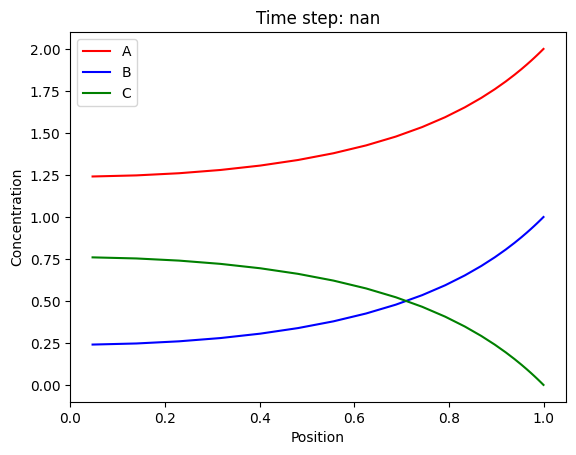

In [4]:
# Create an instance of the diffusion-reaction model
c_b = np.array([2.0, 1.0, 0.0])  # Boundary condition for species B
mrm_model = DiffusionReaction(k=10, c_b=c_b, D=[[1.0, 1.0, 1.0]], nu=3)  # Initialize the model with parameters

# Define a callback function for plotting the concentration profile
def plot_callback(step, model):
    plt.plot(model.r_c, model.c[:, 0], 'r-', label='A')
    plt.plot(model.r_c, model.c[:, 1], 'b-', label='B')
    if model.num_c >= 3:
        plt.plot(model.r_c, model.c[:, 2], 'g-', label='C')
    plt.title(f'Time step: {step * model.dt:.2f}')
    plt.xlabel('Position')
    plt.ylabel('Concentration')
    plt.legend()

# Solve the problem and use the callback function for plotting
mrm_model.solve(callback=plot_callback)

# Compute and print intrinsic and apparent reaction rates
r_intrinsic = mrm_model.reaction_kinetics(c_b).ravel()
print(f"Intrinsic reaction rate at c_A = {c_b[0]:>7.3f} and c_B = {c_b[1]:>7.3f}: r_A = {r_intrinsic[0]:>7.3f}, r_B = {r_intrinsic[1]:>7.3f}, r_C = {r_intrinsic[2]:>7.3f}")
r_apparent = mrm_model.compute_apparent_reaction_rate().ravel()
print(f"Apparent  reaction rate at c_A = {c_b[0]:>7.3f} and c_B = {c_b[1]:>7.3f}: r_A = {r_apparent[0]:>7.3f}, r_B = {r_apparent[1]:>7.3f}, r_C = {r_apparent[2]:>7.3f}")

## Exercises

Here are some suggestions to extend and experiment with the current implementation:

### Vary Diffusion Coefficients
- Assign different diffusion coefficients to the components (e.g., `D = [[1.0, 0.5, 0.1]]`).
- Implement a position-dependent diffusion coefficient using the `set_diff_field` method and observe its impact on the concentration profiles.
- Explore the effect of varying diffusion coefficients relative to the reaction rate and analyze the role of intra-particle mass transfer limitations on the apparent reaction rate.

### Modify Reaction Kinetics
- Change the reaction kinetics to first-order kinetics and compare the results with available analytic solutions.
- Investigate the dependency of the effectiveness factor on the Thiele modulus for planar, cylindrical, and spherical geometries by varying the `nu` parameter.
- Implement nonlinear reaction kinetics (e.g., Langmuir-Hinshelwood) and observe the changes in the concentration profiles and reaction rates.


### Simulate Counter-Diffusion
- Implement a counter-diffusion problem where two species diffuse in opposite directions and react.
- Consider a planar and an annular geometry.
- Analyze the steady-state and transient behavior of the system.

### Investigate Time-Dependent Behavior
- Solve the system for a finite time step size (`dt`) instead of assuming steady-state.
- Visualize the transient behavior of the concentration profiles over time.

### Extend the Model
- Add additional components to the system and define new reaction pathways.
- For example, simulate a reaction network with parallel or consecutive reactions.

Feel free to implement these changes and observe how they impact the results!